In [1]:
# TODO
# Use Toronto data: http://insideairbnb.com/get-the-data/

AirBnb Seattle

- #1: Does higher price mean higher rating? What if we bin listings according to price: Highest, High, Medium, Low, Lowest. And then review the correlations to ratings in each group?
- #2: What if bin listings according to date? What are the price trends through the seasons?
- What if bin listing according to neighborhood. Are there any trends in each neighborhood? Proportion of superhosts in each neighborhood?
- Aside from review what characteristics can be helpful in predicting a hosts rating?
- Can those same factors be used to classify whether a host is a superhost?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',500)

In [4]:
calendar_df = pd.read_csv("./seattle_data/calendar.csv")
listings_df = pd.read_csv("./seattle_data/listings.csv")
reviews_df = pd.read_csv("./seattle_data/reviews.csv")

In [5]:
def explore_data(df):
    print(">>> New DataFrame <<< \n")
    print("df.head(): \n",df.head())
    print("*"*20)
    print("df.shape: \n", df.shape)
    print("*"*20)
    print("df.describe(): \n",df.describe())
    print("*"*20)
    print("df.dtypes: \n",df.dtypes)
    print("*"*20)
    print("df.columns: \n",df.columns)
    print("*"*20)
    print("df.index: \n",df.index)
    print("*"*20)
    print("df.insa().sum(): \n",df.isna().sum())

In [6]:
# df_list = [calendar_df,listings_df,reviews_df]
# for frame in df_list:
#     explore_data(frame)

    

Prepare Data For Analysis

In [7]:
cal_df = calendar_df.copy()
lst_df = listings_df.copy()
rev_df = reviews_df.copy()


Calendar DataFrame

- Duplicate listing_id as a listing may be available on various dates.
- The price of a listing_id may differ depending on date.

In [8]:
cal_df.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [9]:
cal_df.isna().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [10]:
cal_df.dropna(inplace=True)

In [11]:
cal_df['date'] = pd.to_datetime(calendar_df['date'])

In [12]:
cal_df['price'] = cal_df['price'].str.slice(start=1)
cal_df['price'] = cal_df['price'].replace(',','',regex=True)
cal_df['price'] = pd.to_numeric(cal_df['price'], errors='coerce')

In [13]:
cal_df.shape

(934542, 4)

In [14]:
cal_df['available'].nunique()

1

#1: Does higher price mean higher rating? What if we bin listings according to price: Highest, High, Medium, Low, Lowest. And then review the correlations to ratings in each group?

In [15]:
calendar = cal_df.drop(['available','date'],axis=1)
calendar.head()

,listing_id,price
0,241032,85.0
1,241032,85.0
9,241032,85.0
10,241032,85.0
14,241032,85.0


In [16]:
calendar['price_category'] = pd.qcut(calendar['price'],q=5,\
                        labels=['Lowest','Low','Medium','High','Highest']) 

In [17]:
calendar.head()

,listing_id,price,price_category
0,241032,85.0,Low
1,241032,85.0,Low
9,241032,85.0,Low
10,241032,85.0,Low
14,241032,85.0,Low


In [18]:
ratings = lst_df[['id','review_scores_rating']].dropna(axis=0)

In [19]:
calendar_join_ratings = pd.merge(left=calendar,\
                                right=ratings,\
                                left_on="listing_id",\
                                right_on="id")

In [20]:
calendar_join_ratings.head()

,listing_id,price,price_category,id,review_scores_rating
0,241032,85.0,Low,241032,95.0
1,241032,85.0,Low,241032,95.0
2,241032,85.0,Low,241032,95.0
3,241032,85.0,Low,241032,95.0
4,241032,85.0,Low,241032,95.0


In [21]:
joined = calendar_join_ratings.drop(['listing_id','id'],axis=1)
joined.head()

,price,price_category,review_scores_rating
0,85.0,Low,95.0
1,85.0,Low,95.0
2,85.0,Low,95.0
3,85.0,Low,95.0
4,85.0,Low,95.0


In [22]:
price_category_grouped = joined.groupby(['price_category'],as_index=False)

In [23]:
for name,grp in price_category_grouped:
    print(name)
    print(grp[['price','review_scores_rating']].corr())
    print("*"*20)

('Lowest',)
                         price  review_scores_rating
price                 1.000000              0.083507
review_scores_rating  0.083507              1.000000
********************
('Low',)
                         price  review_scores_rating
price                 1.000000              0.018733
review_scores_rating  0.018733              1.000000
********************
('Medium',)
                         price  review_scores_rating
price                 1.000000              0.052364
review_scores_rating  0.052364              1.000000
********************
('High',)
                         price  review_scores_rating
price                 1.000000             -0.003879
review_scores_rating -0.003879              1.000000
********************
('Highest',)
                         price  review_scores_rating
price                 1.000000              0.084067
review_scores_rating  0.084067              1.000000
********************


No significant correlations in the different price groups. As as a sanity check let's review the correlation between price and rating for all listings.

In [24]:
calendar_join_ratings[['price','review_scores_rating']].corr()

,price,review_scores_rating
price,1.000000,0.079414
review_scores_rating,0.079414,1.000000


#2: What if we group listings according not only according to price but also date? Do price fluctuate depending on the season for the listings in the various price categories (Lowest, Low, Medium, High, Highest)?

In [25]:
cal_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
9,241032,2016-01-13,t,85.0
10,241032,2016-01-14,t,85.0
14,241032,2016-01-18,t,85.0


In [26]:
date_df = cal_df.drop(['available'],axis=1)

In [27]:
date_df['month'] = date_df['date'].dt.month

In [28]:
date_df['price_category'] = pd.qcut(date_df['price'],q=5,\
                        labels=['Lowest','Low','Medium','High','Highest']) 

In [29]:
date_grouped = date_df.groupby(['price_category','month'],as_index=False)

In [30]:
for name,grp in date_grouped:
    print(name)
    # print(date_grouped.get_group(name))

('Lowest', 1)
('Lowest', 2)
('Lowest', 3)
('Lowest', 4)
('Lowest', 5)
('Lowest', 6)
('Lowest', 7)
('Lowest', 8)
('Lowest', 9)
('Lowest', 10)
('Lowest', 11)
('Lowest', 12)
('Low', 1)
('Low', 2)
('Low', 3)
('Low', 4)
('Low', 5)
('Low', 6)
('Low', 7)
('Low', 8)
('Low', 9)
('Low', 10)
('Low', 11)
('Low', 12)
('Medium', 1)
('Medium', 2)
('Medium', 3)
('Medium', 4)
('Medium', 5)
('Medium', 6)
('Medium', 7)
('Medium', 8)
('Medium', 9)
('Medium', 10)
('Medium', 11)
('Medium', 12)
('High', 1)
('High', 2)
('High', 3)
('High', 4)
('High', 5)
('High', 6)
('High', 7)
('High', 8)
('High', 9)
('High', 10)
('High', 11)
('High', 12)
('Highest', 1)
('Highest', 2)
('Highest', 3)
('Highest', 4)
('Highest', 5)
('Highest', 6)
('Highest', 7)
('Highest', 8)
('Highest', 9)
('Highest', 10)
('Highest', 11)
('Highest', 12)


In [31]:
categories_data = {'Lowest':[],'Low':[],'Medium':[],'High':[],'Highest':[] }

In [32]:
for name,grp in date_grouped:
    # month_num = name[1]
    # num_listings = grp['listing_id'].count()

    median_price = grp['price'].median()
    price_cat = name[0]
    categories_data[price_cat].append(median_price)

In [33]:
summary_df = pd.DataFrame(data=categories_data,\
                          columns=categories_data.keys())

summary_df

,Lowest,Low,Medium,High,Highest
0,55.0,84.0,109.0,150.0,248.0
1,55.0,84.0,109.0,150.0,249.0
2,55.0,84.0,110.0,150.0,245.0
3,55.0,84.0,110.0,150.0,249.0
4,55.0,85.0,110.0,150.0,250.0
5,55.0,84.0,110.0,150.0,257.0
6,55.0,83.0,110.0,150.0,265.0
7,55.0,85.0,110.0,150.0,265.0
8,55.0,85.0,110.0,150.0,250.0
9,55.0,85.0,110.0,150.0,250.0


In [34]:
def highlight_max(a_col,color):
    return np.where(a_col == np.nanmax(a_col.to_numpy()),\
                    f"color: {color}", None)

summary_df.style.apply(highlight_max,color="red")





,Lowest,Low,Medium,High,Highest
0,55.000000,84.000000,109.000000,150.000000,248.000000
1,55.000000,84.000000,109.000000,150.000000,249.000000
2,55.000000,84.000000,110.000000,150.000000,245.000000
3,55.000000,84.000000,110.000000,150.000000,249.000000
4,55.000000,85.000000,110.000000,150.000000,250.000000
5,55.000000,84.000000,110.000000,150.000000,257.000000
6,55.000000,83.000000,110.000000,150.000000,265.000000
7,55.000000,85.000000,110.000000,150.000000,265.000000
8,55.000000,85.000000,110.000000,150.000000,250.000000
9,55.000000,85.000000,110.000000,150.000000,250.000000


What is the most expensive month for each category? Least expensive?

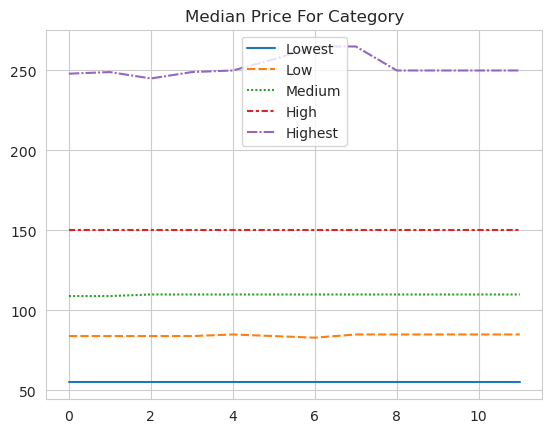

In [35]:
sns.lineplot(data=summary_df).set_title("Median Price For Category")
plt.show()

In [36]:
# categories = ['Lowest','Low','Medium','High','Highest']
# x = [month for month in summary_df['month'].unique()]
# y = {}
# for cat in categories:
#     category_price_series = summary_df[summary_df['price_category'] == cat]['median_price']
#     y[cat] = category_price_series
